In [39]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2 as cv
import skimage
import imageio
import os
import colour
from astropy.io import fits

from colour.models import RGB_COLOURSPACES, RGB_luminance
colorspace = RGB_COLOURSPACES['sRGB']

# Load fits file

In [54]:
wdir = '../../bf_data/examples/'
#fits_img_fn = fits.util.get_testdata_filepath(wdir + 'J000311.00+155754.0-g.fits')
base = lambda bn: wdir + f'J000311.00+155754.0-{bn}.fits'


In [68]:
channels=[]
for bn in ['i','r','g']:
    fits_img_fn = base(bn)
    img = fits.open(fits_img_fn)[0]
    channels.append(img.data)

rgb = np.stack(channels,axis=2)

print(rgb.shape)

(181, 181, 3)


In [63]:
colour.plotting.colour_style()
colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.8.3 | packaged by conda-forge | (default, Jun  1 2020,     *
*   17:43:00)                                                                 *
*                [GCC 7.5.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.15                                                       *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                  

# Try a simple TMO 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


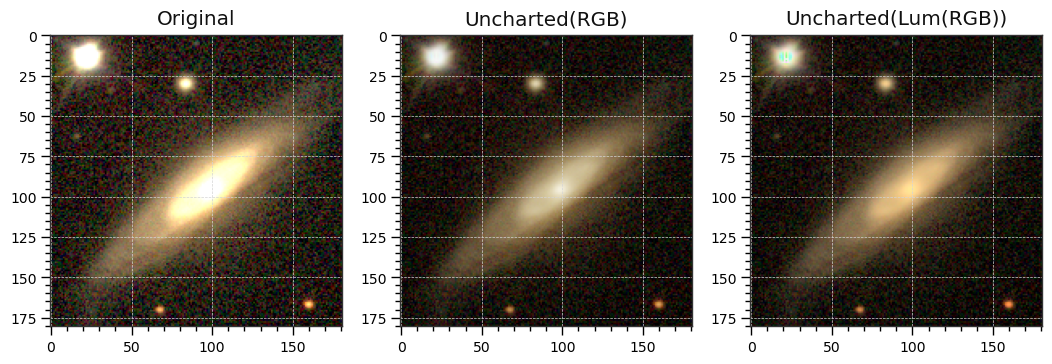

In [69]:
def uncharted(x):
    a = 0.22
    b = 0.30
    c = 0.10
    d = 0.20
    e = 0.01
    f = 0.30

    return ((x * (a * x + c * b) + d * e) / (x * (a * x + b) + d * f)) - e / f

lum = RGB_luminance(rgb, colorspace.primaries, colorspace.whitepoint)
lum_ratio = uncharted(lum)/lum
mapped = rgb* np.expand_dims(lum_ratio, -1)
fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(rgb))
axs[0].set_title("Original")
axs[1].imshow(colour.cctf_encoding(uncharted(rgb)))
axs[1].set_title("Uncharted(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("Uncharted(Lum(RGB))")
plt.show()

## Galaxy Masking

Something like water shed algorithm 

In [ ]:
masked = mask_galaxy(img)

## Impose min max range 

Lower limit of SNR + ignore pixels saturated by non-galactic source?

In [ ]:
# SNR cut





# Choose saturated pixels





# Mask or what? 

## Try some TMO